In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from scipy.fft import rfft

from cohlib.utils import pickle_open, logistic, get_dcval
from cohlib.plot import draw_raster_single
from cohlib.mvcn import gen_random_mvcn_params, sample_mvcn_time_obs
from cohlib.alg.transform import construct_real_idft, construct_real_idft_mod
from cohlib.sample import sample_spikes_from_xs


In [75]:
fs = 1000
sample_length = 1000
K = 2
T = sample_length/fs
Gamma, freqs = gen_random_mvcn_params(T, fs, K)
Gamma_reduce = Gamma.copy()
# Gamma_reduce[:,:,:] = Gamma_reduce*0.1
Gamma_reduce[:,:,:] = Gamma_reduce*0

Gamma_reduce[9,0,0] = 10**(40 / 10) 
Gamma_reduce[9,1,1] = 10**(40 / 10) 

num_freqs_use = 100
Gamma_reduce[num_freqs_use:,:,:] = 0


freqs_reduce = freqs
L = 500
Wv = construct_real_idft(sample_length, freqs.size, fs)
# Wv = construct_real_idft_mod(sample_length, freqs.size, num_freqs_use, fs)
Wv_reduce = Wv
J_orig = int(sample_length / 2)
n_freqs = freqs.size


In [76]:
def _c_sample_func_bernoulli(C):
    def func(x):
        reps = np.tile(x, C).reshape(C,-1)
        samples = np.random.binomial(1, reps)
        return samples
    return func

def _c_sample_func_pois(C):
    def func(x):
        samples = np.random.poisson(x, size=(C,x.size))
        return samples
    return func

Figure 1: 
- A) Theoretical spectrum $S_{\Lambda}$ 
- B) $\lambda_t^{\ell}$ - Three draws from $S_{\Lambda}$
- C) Theoretical spectrum $S_{N}$ 
- D) $n_t^{\ell}$ Three draws from $N_t^{\vert \Lambda}$

In [77]:
# dc_vals = np.array([get_dcval(mu, n_freqs) for k in range(K)])
dc_vals = np.array([0 for k in range(K)])
xs, _, _ = sample_mvcn_time_obs(Gamma_reduce*200, L, freqs_reduce, Wv_reduce, dc_vals, return_all=True)
x = xs[:,0,:]
# plt.plot(x[0,:]) 

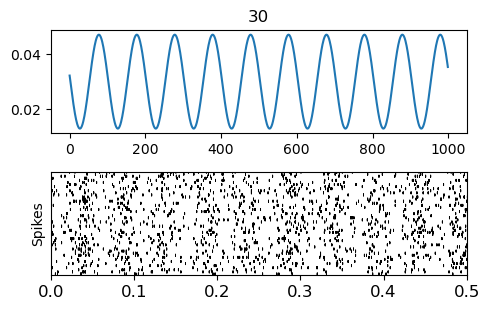

In [78]:
mus = [30]
for mu in mus:
    rates = (x + mu) * 1e-3
    rates[rates < 0 ] = 0
    spks = sample_spikes_from_xs(rates, 50)
    fig, ax = plt.subplots(2,1,figsize=(5,3))
    l = 0
    ax[0].plot(rates[l,:] )
    draw_raster_single(spks[l,:,:], ax=ax[1])
    plt.tight_layout()
    ax[0].set_title(f'{mu}')
    plt.show()

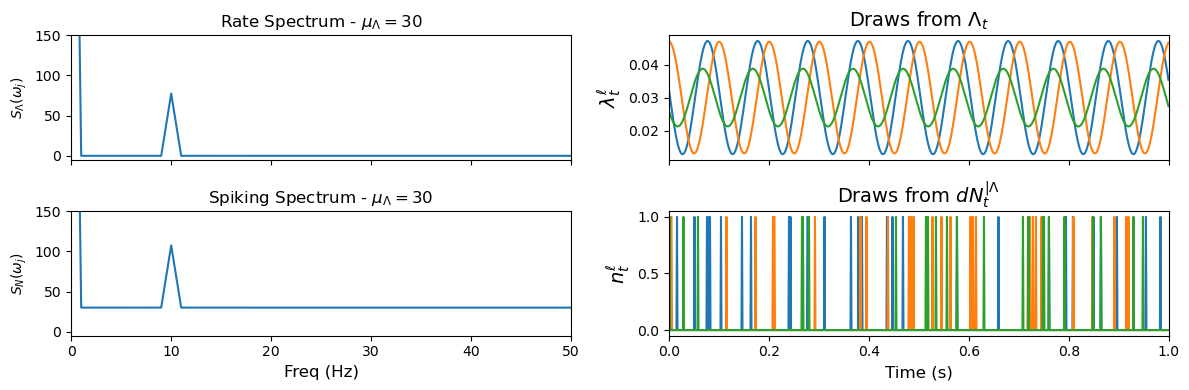

In [79]:
time = np.arange(1000) / 1e3
fmin_show = 0
freqs = np.arange(0,501)
lam_gauss = rates
ft_lam_gauss = rfft(lam_gauss[:L,:], axis=1, norm='backward')
ft_n_gauss = rfft(spks[:L,0,:], axis=1, norm='backward')
S_lam_gauss = (ft_lam_gauss * ft_lam_gauss.conj()).mean(0).real
S_n_gauss = (ft_n_gauss * ft_n_gauss.conj()).mean(0).real
fig, ax = plt.subplots(2,2,figsize=(12,4))
ax[0,0].plot(freqs, S_lam_gauss[fmin_show:])
ax[0,0].set_xlim([0,50])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim([-5,150])
ax[0,0].set_ylabel(r'$S_{\Lambda}(\omega_j)$')
ax[0,0].set_title(r'Rate Spectrum - $\mu_{\Lambda} = 30$')
for l in range(3):
    ax[0,1].plot(time, lam_gauss[l,:])
    ax[0,1].set_xlim([0,1])
ax[0,1].set_ylabel(r'$\lambda_t^{\ell}$', fontsize=14)
ax[0,1].set_title(r'Draws from $\Lambda_t$', fontsize=14)
ax[0,1].set_xticklabels([])
ax[1,0].plot(freqs, 30 + S_lam_gauss[fmin_show:])
ax[1,0].set_xlim([0,50])
ax[1,0].set_ylim([-5,150])
ax[1,0].set_title(r'Spiking Spectrum - $\mu_{\Lambda} = 30$')
ax[1,0].set_ylabel(r'$S_N(\omega_j)$')
ax[1,0].set_xlabel(r'Freq (Hz)', fontsize=12)
for l in range(3):
    ax[1,1].plot(time,spks[l,1,:])
    ax[1,1].set_xlim([0,1])
ax[1,1].set_title(r'Draws from $dN^{\vert \Lambda}_t$', fontsize=14)
ax[1,1].set_ylabel(r'$n_t^{\ell}$', fontsize=14)
ax[1,1].set_xlabel(r'Time (s)', fontsize=12)
plt.tight_layout()

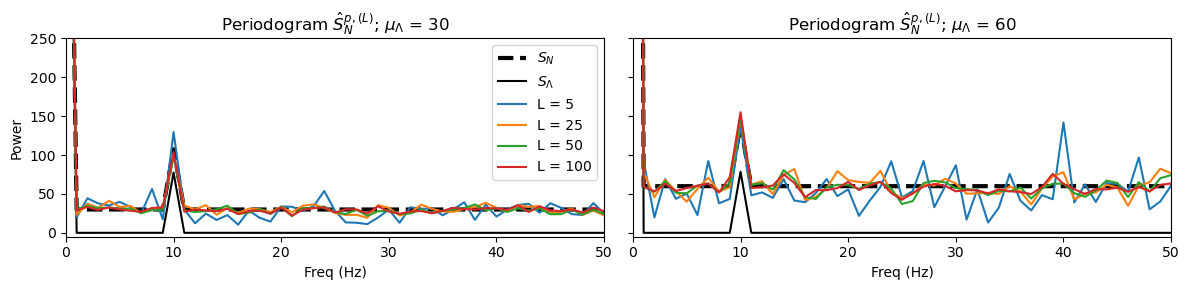

In [95]:
time = np.arange(1000) / 1e3
fmin_show = 0
freqs = np.arange(0,501)

fig, ax = plt.subplots(1,2,figsize=(12,3), sharey=True)
mus = [30,60]
Ls = [5, 25, 50, 100]
for m, mu in enumerate(mus):
    rates = (x + mu) * 1e-3
    rates[rates < 0 ] = 0
    spks = sample_spikes_from_xs(rates, 5)
    lam_gauss = rates
    ft_lam_gauss = rfft(lam_gauss[:500,:], axis=1, norm='backward')
    S_lam_gauss = (ft_lam_gauss * ft_lam_gauss.conj()).mean(0).real
    ax[m].plot(freqs, mu + S_lam_gauss[fmin_show:], color='black', linestyle='--', linewidth=3, label=r'$S_{N}$')
    ax[m].plot(freqs, S_lam_gauss[fmin_show:], color='black', label=r'$S_{\Lambda}$')

    for L in Ls:
        ft_n_gauss = rfft(spks[:L,0,:], axis=1, norm='backward')
        S_n_gauss = (ft_n_gauss * ft_n_gauss.conj()).mean(0).real
        ax[m].plot(freqs, S_n_gauss[fmin_show:], label=f'L = {L}')

    ax[m].set_xlim([0,50])
    ax[m].set_ylim([-5,250])
    ax[m].set_xlabel('Freq (Hz)')
    # ax[m].set_ylabel(r'$S_{\Lambda}(\omega_j)$')
    ax[m].set_title(r'Periodogram $\hat{S}_N^{p,(L)}$; $\mu_{\Lambda}$' + f' = {mu}')
    if m == 0:
        ax[m].legend()
        ax[m].set_ylabel('Power')
    plt.tight_layout() 

In [101]:

g_vars = np.arange(2, 12, 2)*1e-2
g_vars

array([0.02, 0.04, 0.06, 0.08, 0.1 ])

In [114]:
dc_vals = np.array([0 for k in range(K)])
xs, _, _ = sample_mvcn_time_obs(Gamma_reduce*200, 5000, freqs_reduce, Wv_reduce, dc_vals, return_all=True)
x = xs[:,0,:]

In [129]:
gvars

[0.03, 0.06]

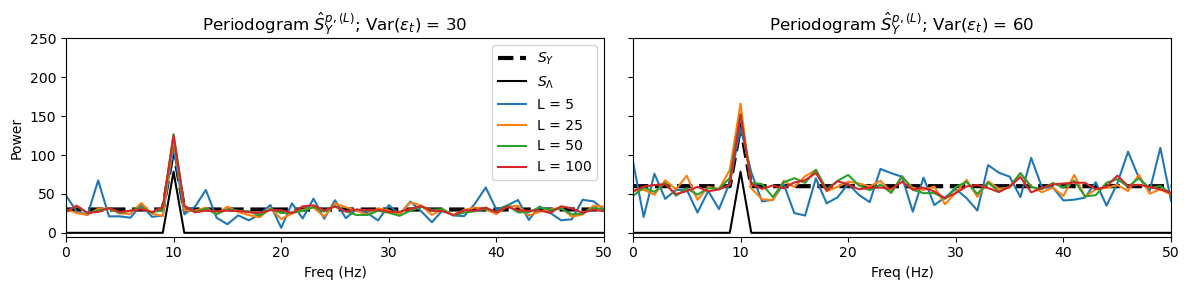

In [132]:
time = np.arange(1000) / 1e3
fmin_show = 0
freqs = np.arange(0,501)

fig, ax = plt.subplots(1,2,figsize=(12,3), sharey=True)
mu = 30
gvars = [0.3*1e-1, 0.6*1e-1]
# Ls = [5, 10, 50, 100, 250]
Ls = [5, 25, 50, 100]
for m, gvar in enumerate(gvars):
    rates = (x) * 1e-3
    # rates[rates < 0 ] = 0
    # spks = sample_spikes_from_xs(rates, 5)
    spks = rates + np.random.randn(*rates.shape)*np.sqrt(gvar)
    lam_gauss = rates
    ft_lam_gauss = rfft(lam_gauss[:500,:], axis=1, norm='backward')
    S_lam_gauss = (ft_lam_gauss * ft_lam_gauss.conj()).mean(0).real
    # ft_y_gauss = rfft(spks[:5000,:], axis=1, norm='backward')
    # S_y_gauss = (ft_y_gauss * ft_y_gauss.conj()).mean(0).real
    # ax[m].plot(freqs, mu + S_lam_gauss[fmin_show:], color='black', linestyle='--', linewidth=3, label=r'$S_{N}$')
    ax[m].plot(freqs, gvar*1e3 + S_lam_gauss[fmin_show:], color='black', linestyle='--', linewidth=3, label=r'$S_{Y}$')
    ax[m].plot(freqs, S_lam_gauss[fmin_show:], color='black', label=r'$S_{\Lambda}$')

    for L in Ls:
        ft_n_gauss = rfft(spks[:L,:], axis=1, norm='backward')
        S_n_gauss = (ft_n_gauss * ft_n_gauss.conj()).mean(0).real
        ax[m].plot(freqs, S_n_gauss[fmin_show:], label=f'L = {L}')

    ax[m].set_xlim([0,50])
    ax[m].set_ylim([-5,250])
    ax[m].set_xlabel('Freq (Hz)')
    # ax[m].set_ylabel(r'$S_{\Lambda}(\omega_j)$')
    ax[m].set_title(r'Periodogram $\hat{S}_Y^{p,(L)}$; $\text{Var}(\varepsilon_t)$' + f' = {int(gvar*1e3)}')
    if m == 0:
        ax[m].legend()
        ax[m].set_ylabel('Power')
    plt.tight_layout() 

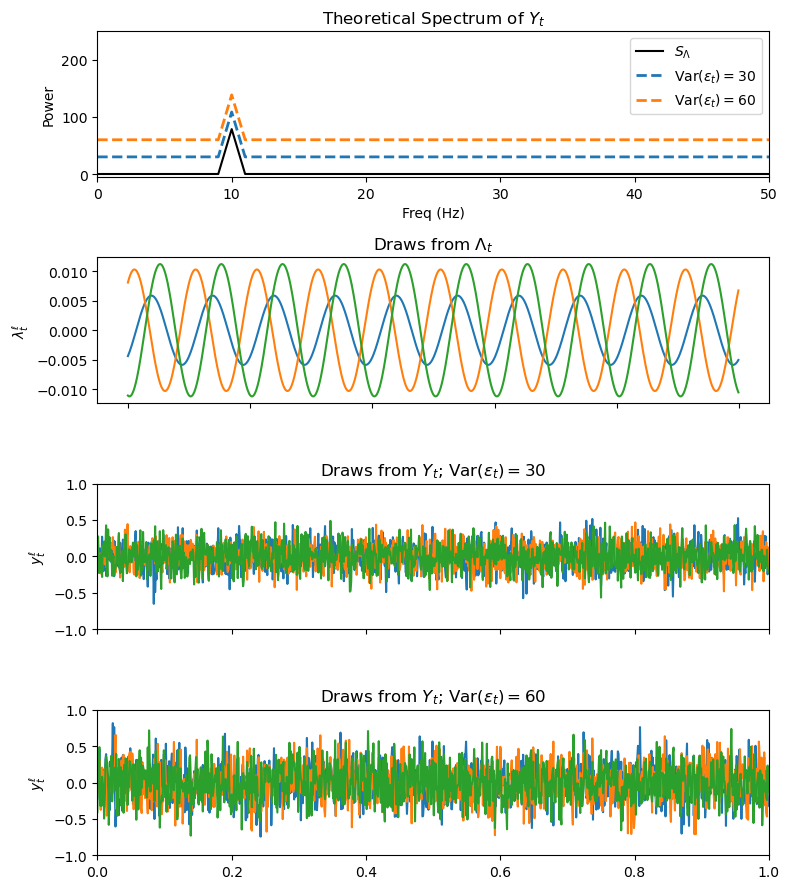

In [156]:
time = np.arange(1000) / 1e3
fmin_show = 0
freqs = np.arange(0,501)

fig, ax = plt.subplots(4,1,figsize=(8,9))
mu = 30
gvars = [0.3*1e-1, 0.6*1e-1]
# Ls = [5, 10, 50, 100, 250]
Ls = [5, 25, 50, 100]
ax[0].plot(freqs, S_lam_gauss[fmin_show:], color='black', label=r'$S_{\Lambda}$')
ax[0].set_ylabel('Power')
ax[0].set_title('Theoretical Spectrum of $Y_t$')
rates = (x) * 1e-3
for l in range(3):
    ax[1].plot(time, rates[l,:])
ax[1].set_title(r'Draws from $\Lambda_t$')
ax[1].set_ylabel(r'$\lambda_t^{\ell}$')
for g, gvar in enumerate(gvars):
    # rates[rates < 0 ] = 0
    # spks = sample_spikes_from_xs(rates, 5)
    spks = rates + np.random.randn(*rates.shape)*np.sqrt(gvar)
    lam_gauss = rates
    ft_lam_gauss = rfft(lam_gauss[:500,:], axis=1, norm='backward')
    S_lam_gauss = (ft_lam_gauss * ft_lam_gauss.conj()).mean(0).real
    # ft_y_gauss = rfft(spks[:5000,:], axis=1, norm='backward')
    # S_y_gauss = (ft_y_gauss * ft_y_gauss.conj()).mean(0).real
    # ax[m].plot(freqs, mu + S_lam_gauss[fmin_show:], color='black', linestyle='--', linewidth=3, label=r'$S_{N}$')
    ax[0].plot(freqs, gvar*1e3 + S_lam_gauss[fmin_show:], linestyle='--', linewidth=2, label=r'$\text{Var}(\varepsilon_t) = $' + f'{int(gvar*1e3)}')

    for l in range(3):
        ax[g+2].plot(time, spks[l,:])
        # ft_n_gauss = rfft(spks[:L,:], axis=1, norm='backward')
        # S_n_gauss = (ft_n_gauss * ft_n_gauss.conj()).mean(0).real
        # ax[m].plot(freqs, S_n_gauss[fmin_show:], label=f'L = {L}')
        ax[g+2].set_xlim([0,1])
        ax[g+2].set_ylim([-1,1])
        ax[g+2].set_title(r'Draws from $Y_t$; $\text{Var}(\varepsilon_t) = $' + f'{int(gvar*1e3)}')
        ax[g+2].set_ylabel(r'$y_t^{\ell}$')

    ax[0].set_xlim([0,50])
    ax[0].set_ylim([-5,250])
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xticklabels([])
    ax[2].set_xticklabels([])
ax[0].legend(loc='upper right')

    # ax[m].set_ylabel(r'$S_{\Lambda}(\omega_j)$')
    # ax[m].set_title(r'Periodogram $\hat{S}_Y^{p,(L)}$; $\text{Var}(\varepsilon_t)$' + f' = {int(gvar*1e3)}')
    # if m == 0:
    #     ax[m].legend()
    #     ax[m].set_ylabel('Power')
plt.tight_layout() 

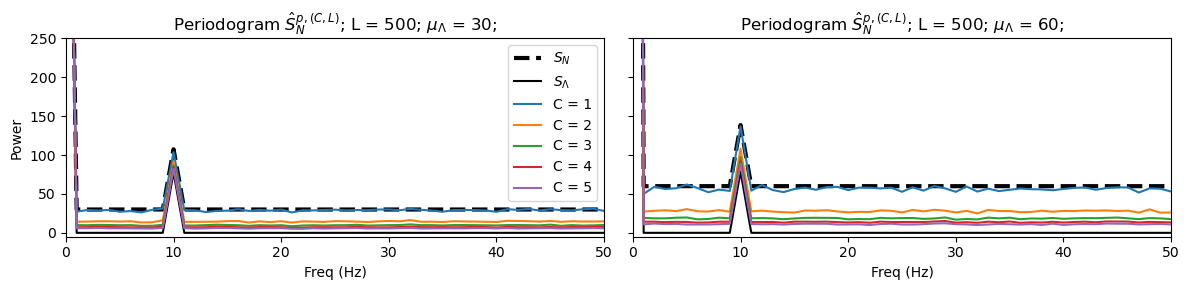

In [98]:
time = np.arange(1000) / 1e3
fmin_show = 0
freqs = np.arange(0,501)

fig, ax = plt.subplots(1,2,figsize=(12,3), sharey=True)
mus = [30,60]
L = 500
Cs = [1, 2, 3, 4, 5]
for m, mu in enumerate(mus):
    rates = (x + mu) * 1e-3
    rates[rates < 0 ] = 0
    spks = sample_spikes_from_xs(rates, 5)
    lam_gauss = rates
    ft_lam_gauss = rfft(lam_gauss[:500,:], axis=1, norm='backward')
    S_lam_gauss = (ft_lam_gauss * ft_lam_gauss.conj()).mean(0).real
    ax[m].plot(freqs, mu + S_lam_gauss[fmin_show:], color='black', linestyle='--', linewidth=3, label=r'$S_{N}$')
    ax[m].plot(freqs, S_lam_gauss[fmin_show:], color='black', label=r'$S_{\Lambda}$')

    for C in Cs:
        spikes = spks[:L,:C,:].mean(1)
        ft_spikes = rfft(spikes, axis=1, norm='backward')
        S_spikes = (ft_spikes * ft_spikes.conj()).mean((0)).real
        ax[m].plot(freqs, S_spikes[fmin_show:], label=f'C = {C}')

    ax[m].set_xlim([0,50])
    ax[m].set_ylim([-5,250])
    ax[m].set_xlabel('Freq (Hz)')
    # ax[m].set_ylabel(r'$S_{\Lambda}(\omega_j)$')
    ax[m].set_title(r'Periodogram $\hat{S}_N^{p,(C,L)}$; L = 500; $\mu_{\Lambda}$' + f' = {mu};')
    if m == 0:
        ax[m].legend()
        ax[m].set_ylabel('Power')
    plt.tight_layout() 

In [26]:
C


500

In [53]:
from scipy.fft import irfft
mu = 30
rates = (mu*np.ones_like(x)) * 1e-3
rates[rates < 0 ] = 0
C = 1
spikes_gauss = sample_spikes_from_xs(rates, C)

spikes = spikes_gauss[:L,:C,:].mean(1)
spikes_mc = (spikes_gauss[:L,:C,:] - spikes_gauss[:L,:C,:].mean(2)[:,:,None]).mean(1)
ft_spikes_mc = rfft(spikes_mc, axis=1, norm='backward')

norm_gauss = rates + np.random.randn(*rates.shape) * np.sqrt(3*1e-2)
ft_norm_mc = rfft(norm_gauss, axis=1, norm='backward')

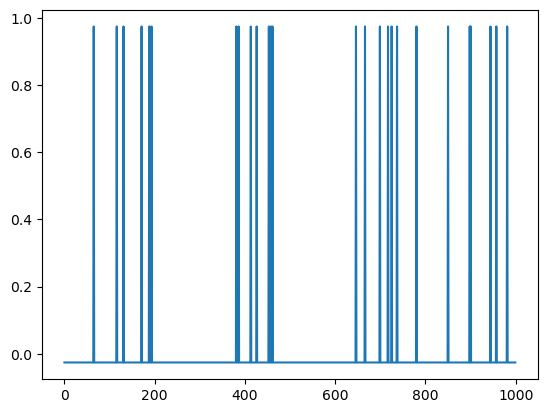

In [54]:
plt.plot(spikes_mc[0,:])

In [55]:
Sn = np.einsum('ij,ik->ijk', ft_spikes_mc, ft_spikes_mc.conj()).mean(0)
plt.plot(np.diag(Sn.real)[1:])

MemoryError: Unable to allocate 1.87 GiB for an array with shape (500, 501, 501) and data type complex128

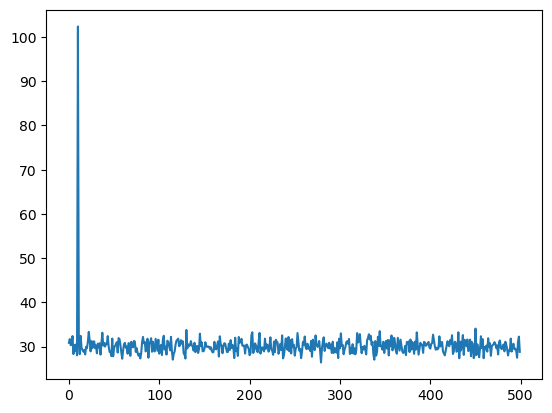

In [12]:
Sy = np.einsum('ij,ik->ijk', ft_norm_mc, ft_norm_mc.conj()).mean(0)
plt.plot(np.diag(Sy.real)[1:])

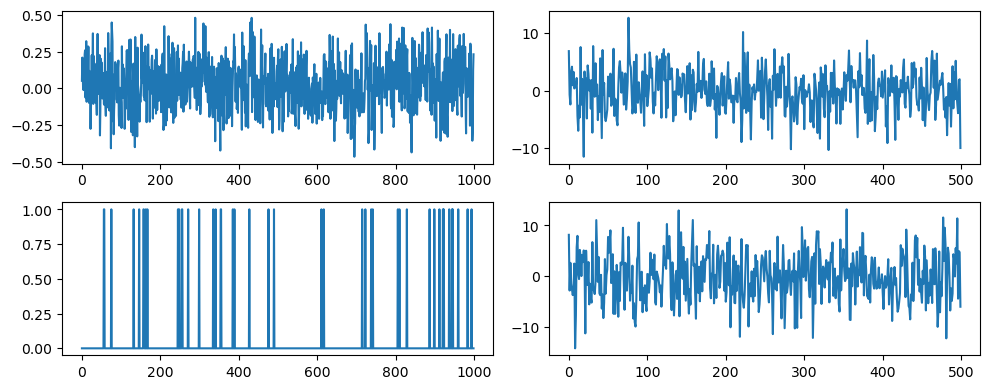

In [31]:
fig, ax = plt.subplots(2,2,figsize=(10,4))
l = 0
ax[0,0].plot(norm_gauss[l,:])
ax[1,0].plot(spikes[l,:])
ax[0,1].plot(ft_norm_mc[l,1:].real)
ax[1,1].plot(ft_spikes_mc[l,1:].real)

plt.tight_layout()

In [47]:
np.tile(np.arange(5),3)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

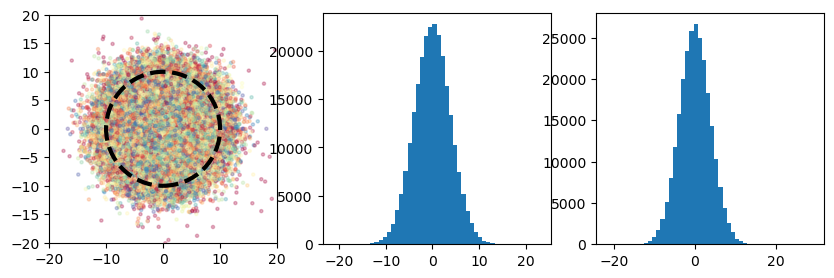

In [50]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
# ax[0].scatter(ft_norm_mc[0,1:].real, ft_norm_mc[0,1:].imag, c=np.arange(500), s=np.ones(500)*5, cmap='Spectral', alpha=0.9)
# ax[1].hist(ft_norm_mc[0,1:].real, bins=50)
# ax[2].hist(ft_norm_mc[0,1:].imag, bins=50)
# plt.scatter(x, x, c=x, cmap=plt.get_cmap('Blues'))

ax[0].scatter(ft_norm_mc[:,1:].flatten().real, ft_norm_mc[:,1:].flatten().imag, c=np.tile(np.arange(500),500), s=np.tile(np.ones(500)*5,500), cmap='Spectral', alpha=0.3)
ax[1].hist(ft_norm_mc[:,1:].flatten().real, bins=50)
ax[2].hist(ft_norm_mc[:,1:].flatten().imag, bins=50)
b = 20
circle1 = plt.Circle((0.0, 0.0), b/2, color='black', linewidth=3, linestyle='--', fill=False)
ax[0].add_patch(circle1)
ax[0].set_xlim([-b,b])
ax[0].set_ylim([-b,b])
ax[0].set_aspect('equal', adjustable='box')

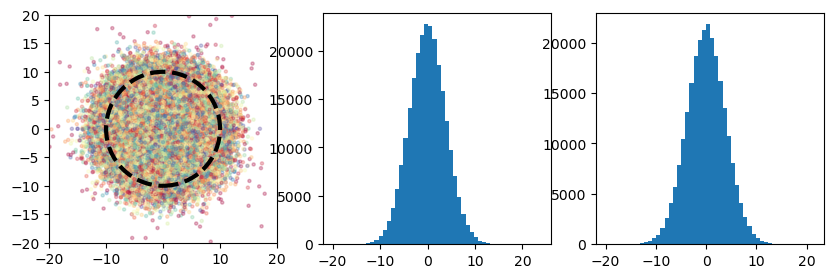

In [51]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
# ax[0].scatter(ft_spikes_mc[0,1:].real, ft_spikes_mc[0,1:].imag, c=np.arange(500), s=np.ones(500)*5, cmap='Spectral', alpha=0.9)
# ax[1].hist(ft_spikes_mc[0,1:].real, bins=50)
# ax[2].hist(ft_spikes_mc[0,1:].imag, bins=50)
# plt.scatter(x, x, c=x, cmap=plt.get_cmap('Blues'))

ax[0].scatter(ft_spikes_mc[:,1:].flatten().real, ft_spikes_mc[:,1:].flatten().imag, c=np.tile(np.arange(500),500), s=np.tile(np.ones(500)*5,500), cmap='Spectral', alpha=0.3)
ax[1].hist(ft_spikes_mc[:,1:].flatten().real, bins=50)
ax[2].hist(ft_spikes_mc[:,1:].flatten().imag, bins=50)
b = 20
circle1 = plt.Circle((0.0, 0.0), b/2, color='black', linewidth=3, linestyle='--', fill=False)
ax[0].add_patch(circle1)
ax[0].set_xlim([-b,b])
ax[0].set_ylim([-b,b])
ax[0].set_aspect('equal', adjustable='box')

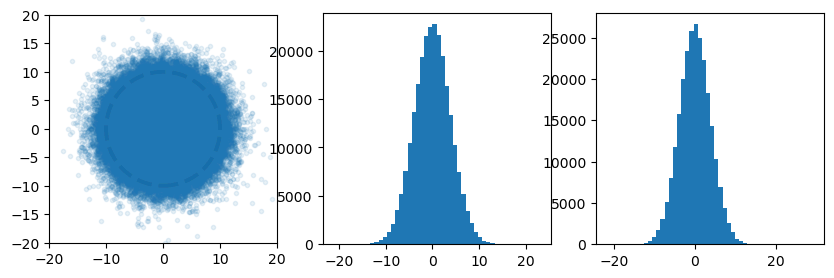

In [32]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(ft_norm_mc[:,1:].real.flatten(), ft_norm_mc[:,1:].imag.flatten(), '.', alpha=0.1)
ax[1].hist(ft_norm_mc[:,1:].real.flatten(), bins=50)
ax[2].hist(ft_norm_mc[:,1:].imag.flatten(), bins=50)
b = 20
circle1 = plt.Circle((0.0, 0.0), b/2, color='black', linewidth=3, linestyle='--', fill=False)
ax[0].add_patch(circle1)
ax[0].set_xlim([-b,b])
ax[0].set_ylim([-b,b])
ax[0].set_aspect('equal', adjustable='box')



In [35]:
ft_norm_mc.shape

(500, 501)

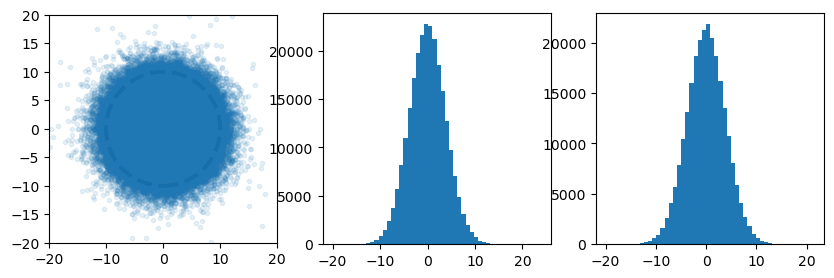

In [33]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(ft_spikes_mc[:,1:].real.flatten(), ft_spikes_mc[:,1:].imag.flatten(), '.', alpha=0.1)
ax[1].hist(ft_spikes_mc[:,1:].real.flatten(), bins=50)
ax[2].hist(ft_spikes_mc[:,1:].imag.flatten(), bins=50)
b = 20
circle1 = plt.Circle((0.0, 0.0), b/2, color='black', linewidth=3, linestyle='--', fill=False)
ax[0].add_patch(circle1)
ax[0].set_xlim([-b,b])
ax[0].set_ylim([-b,b])
ax[0].set_aspect('equal', adjustable='box')



In [ ]:
ax[0,1].plot(ft_norm_mc[l,:].imag)

In [ ]:
test = Sy @ ft_spikes_mc[:,:].swapaxes(0,1)

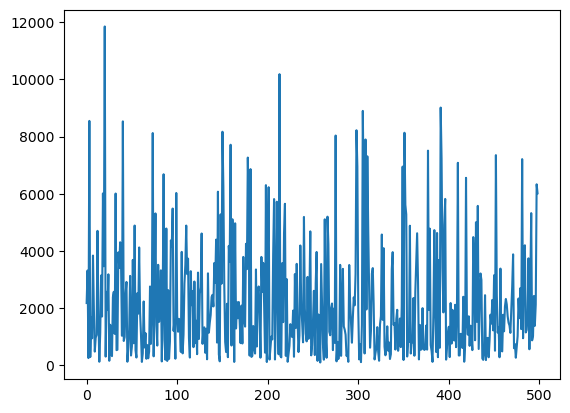

In [ ]:
Snew = np.einsum('ij,ik->ijk', test, test.conj()).mean(0)
plt.plot(np.diag(Snew.real)[1:])

In [ ]:
itest = irfft(test)

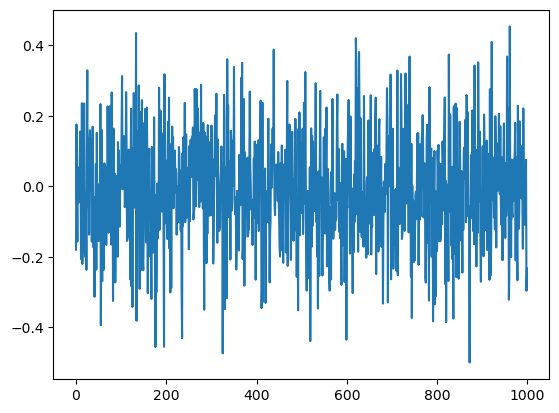

In [ ]:
plt.plot(itest)